In [1]:
import random 

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
from madigan.environments import make_env
from madigan.environments.cpp import Env
from madigan.utils.preprocessor import make_preprocessor

from madigan.utils import make_config, State
from madigan.utils import ReplayBuffer, SARSD, DiscreteActionSpace
from madigan.utils import list_2_dict, reduce_train_metrics


from madigan.run.test import test
from madigan.utils.plotting import plot_test_metrics

In [210]:
global device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = make_config(
        experiment_id="SineQ",
        basepath="/media/hemu/Data/Markets/farm",
        overwrite_exp=False,
        test_steps=1_000,
        nsteps=1000_000,
        assets=["sine1"],
        preprocessor_type="WindowedStacker",
        window_length=64,
        agent_type = "LQN",
        discrete_actions=True,
        discrete_action_atoms=3,
        model_class="LinearModel",
        lr=1e-3,
        double_dqn=True,
        target_update_freq=1200,
        rb_size=10_000,
        min_rb_size=500,
        batch_size=64,
        lot_unit_value=100_000,
        generator_params={
            'freq':[1.],
            'mu':[2.],
            'amp':[1.],
            'phase':[0.],
            'dX':0.01,
            "noise": 0.01}
    )
config

{'basepath': '/media/hemu/Data/Markets/farm',
 'experiment_id': 'SineQ',
 'parent_id': '',
 'overwrite_exp': False,
 'env_type': 'Synth',
 'data_source_type': 'Synth',
 'init_cash': 1000000,
 'required_margin': 1.0,
 'maintenance_margin': 0.25,
 'generator_params': {'freq': [1.0],
  'mu': [2.0],
  'amp': [1.0],
  'phase': [0.0],
  'dX': 0.01,
  'noise': 0.01},
 'assets': ['sine1'],
 'lot_unit_value': 100000,
 'n_assets': 1,
 'discrete_actions': True,
 'discrete_action_atoms': 3,
 'preprocessor_type': 'WindowedStacker',
 'preprocessor_config': {'window_length': 64},
 'agent_type': 'LQN',
 'nsteps': 1000000,
 'test_steps': 1000,
 'rb_size': 10000,
 'min_rb_size': 500,
 'train_freq': 4,
 'target_update_freq': 1200,
 'test_freq': 32000,
 'log_freq': 10000,
 'model_save_freq': 64000,
 'min_tf': 64,
 'batch_size': 64,
 'agent_config': {'type': 'LQN',
  'basepath': '/media/hemu/Data/Markets/farm',
  'model_config': {'model_class': 'LinearModel',
   'd_model': 256,
   'n_layers': 4,
   'n_feat

## Env

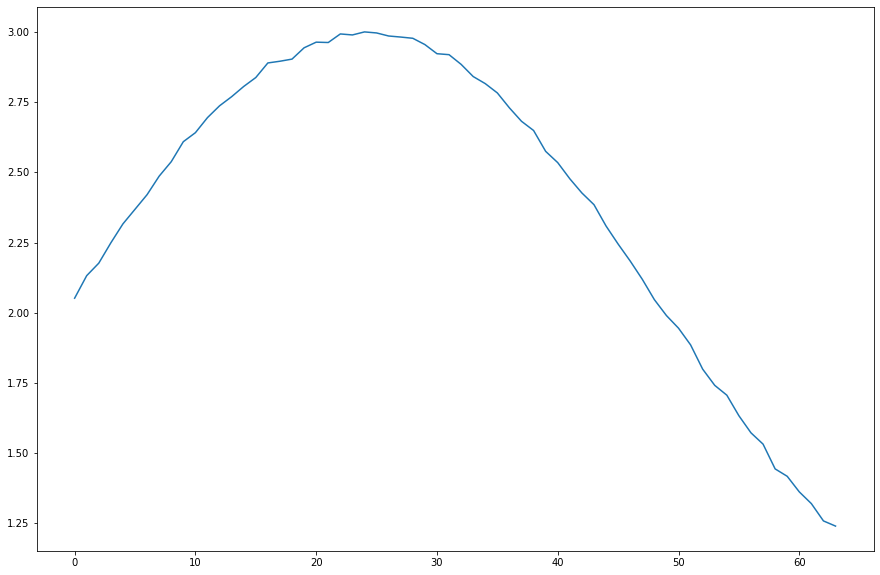

In [211]:
env = make_env(config)
preprocessor = make_preprocessor(config)
env.currentPrices
preprocessor.initialize_history(env)
plt.plot(preprocessor.current_data().price)

## Agent

In [212]:
class Agent:
    def __init__(self, config, device=None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.action_atoms = config.discrete_action_atoms
        self.lot_unit_value = config.lot_unit_value
        actions = [self.lot_unit_value*action - self.action_atoms//2 for action in range(self.action_atoms)]
        probs = [1/len(actions) for i in actions]
        self._action_space = DiscreteActionSpace(actions, probs, len(config.assets))

        input_size = config.preprocessor_config.window_length + len(config.assets)
        self.model_b = nn.Linear(input_size, self.action_atoms).to(device).float()
        self.model_t = nn.Linear(input_size, self.action_atoms).to(device).float()
        
        self.discount = config.agent_config.discount
        
        self.opt = torch.optim.Adam(self.model_b.parameters(), lr=config.agent_config.optim_config.lr)
        self.config = config
        
    @property
    def action_space(self):
        return self._action_space
    
    def prep_state(self, x):
        price = x.price[None, ..., 0]
        x = np.concatenate([price, x.portfolio[None, ...]], axis=-1)
        return torch.from_numpy(x).float().to(self.device)
    
    def get_qvals(self, x):
        x = self.prep_state(x)
        return self.model_t(x).detach()
    
    def action_to_transaction(self, actions):
        return self.lot_unit_value * (actions - (self.action_atoms // 2)).cpu().numpy()
        
    def __call__(self, x):
        with torch.no_grad():
            x = self.prep_state(x)
            qvals = self.model_t(x)
            actions = qvals.max(-1)[1]
            return self.action_to_transaction(actions)
        
    def prep_sarsd(self, sarsd):
        state = State(
            price = torch.as_tensor(sarsd.state.price[..., 0], 
                                    dtype=torch.float32).to(self.device),
            portfolio = torch.as_tensor(sarsd.state.portfolio, 
                                        dtype=torch.float32).to(self.device),
            timestamp = sarsd.state.timestamp
        )
        action = np.rint(sarsd.action // self.lot_unit_value) + self.action_atoms//2
        action = torch.as_tensor(action, dtype=torch.long, device=self.device)[..., 0]
        reward = torch.as_tensor(sarsd.reward, dtype=torch.float32, device=self.device)
        next_state = State(
            price = torch.as_tensor(sarsd.next_state.price[..., 0], 
                                    dtype=torch.float32, device=self.device),
            portfolio = torch.as_tensor(sarsd.next_state.portfolio, 
                                        dtype=torch.float32, device=self.device),
            timestamp = sarsd.next_state.timestamp
        )
        done = torch.as_tensor(sarsd.done, dtype=torch.bool, device=self.device)
        state = torch.cat([state.price, state.portfolio], dim=-1)
        next_state = torch.cat([next_state.price, next_state.portfolio], dim=-1)
        return state, action, reward, next_state, done
    
    def loss_fn(self, Qt, Gt):
        return F.smooth_l1_loss(Qt, Gt)
    
    def train_step(self, sarsd):
        state, action, reward, next_state, done = self.prep_sarsd(sarsd)
        self.opt.zero_grad()
        with torch.no_grad():
            greedy_qvals_next = self.model_t(next_state).max(-1)[0]
            Gt = reward + (~done*self.discount * greedy_qvals_next)
        action_mask = F.one_hot(action, self.action_atoms).to(self.device)
        qvals = self.model_b(state)
        Qt = (qvals*action_mask).sum(-1)
        
        loss = self.loss_fn(Qt, Gt)
        loss.backward()
        self.opt.step()
        
        td_error = (Gt-Qt).abs().mean().detach().item()
        return {'loss': loss.detach().item(), 'td_error': td_error, 'Qt': Qt.detach(), 'Gt': Gt.detach()}

In [213]:
agent = Agent(config, device=device)
x = preprocessor.current_data()
qvals = agent.get_qvals(x)
action = agent(x)
print(qvals, action)

tensor([[ 1.2065,  1.0034, -1.3669]], device='cuda:0') [-100000]


## Training


In [222]:
def trainer(agent, env, preprocessor, config):
    rb = ReplayBuffer(config.rb_size)
    min_rb_size = config.min_rb_size
    target_update_freq = config.target_update_freq
    
    eps = 1.
    eps_decay = 0.99999
    env.reset()
    preprocessor.initialize_history(env)
    state = preprocessor.current_data()
    i = 0
    while True:
        trn_metrics=None
        
        if random.random() < eps:
#             actions = random.sample([-config.lot_unit_value, 0, config.lot_unit_value], 1)
            if state.price[-1] == 1.:
                actions = np.array([agent.lot_unit_value])
            elif state.price[-1] == 3.:
                actions = np.array([-agent.lot_unit_value])
            else:
                actions = np.array([0.])
        else:
            actions = agent(state)
        eps *= eps_decay
        
#         Prevent double positon
#         for i, action in enumerate(actions):
#             if np.sign(action) == np.sign(env.ledger):
#                 actions[i] = 0.
                
        _next_state, reward, done, info = env.step(actions)
        reward = max(-1., min(reward, 1.))
        preprocessor.stream_state(_next_state)
        next_state = preprocessor.current_data()
        sarsd = SARSD(state, actions, reward, next_state, done)
        rb.add(sarsd)
        
        if done:
            env.reset()
            preprocessor.initialize_history(env)
            state = preprocessor.current_data()
        else:
            state = next_state
        if len(rb) >= min_rb_size:
            sarsd = rb.sample(config.batch_size)
            trn_metrics = agent.train_step(sarsd)
            trn_metrics['eps'] = eps
        if i % target_update_freq == 0:
            agent.model_t.load_state_dict(agent.model_b.state_dict())
            
        yield trn_metrics
        i += 1

In [223]:
env = make_env(config)
preprocessor = make_preprocessor(config)
env.currentPrices
preprocessor.initialize_history(env)
agent = Agent(config, device=device)

train_loop = iter(trainer(agent, env, preprocessor, config))
train_metrics=[]

In [224]:
iterations = 50000

for i in tqdm(range(iterations)):
    metrics = next(train_loop)
    if metrics is not None:
        train_metrics.append(metrics)
print('eps', metrics['eps'])


eps 0.8187299343429234


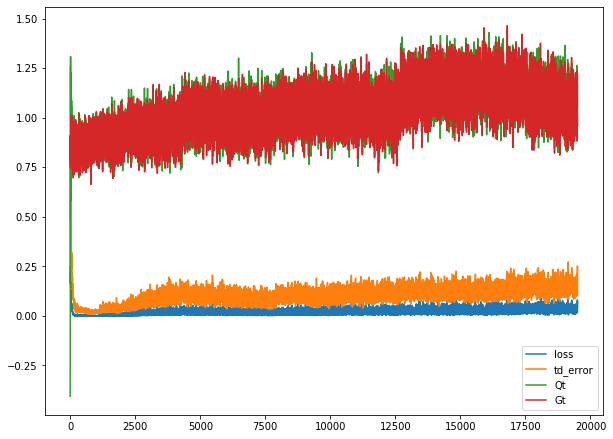

In [225]:
from IPython.core.pylabtools import figsize

figsize(10, 7.5)

trn_metrics = reduce_train_metrics(list_2_dict(train_metrics), ['Qt', 'Gt'])

plt.plot(trn_metrics['loss'], label='loss')
plt.plot(trn_metrics['td_error'], label='td_error')
plt.plot(trn_metrics['Qt'], label='Qt')
plt.plot(trn_metrics['Gt'], label='Gt')
plt.legend()


In [228]:
tst_metrics = test(agent, env, preprocessor, verbose=True)
print(tst_metrics.keys())

dict_keys(['equity', 'returns', 'prices', 'positions', 'assets', 'cash', 'margin', 'actions', 'states', 'qvals'])


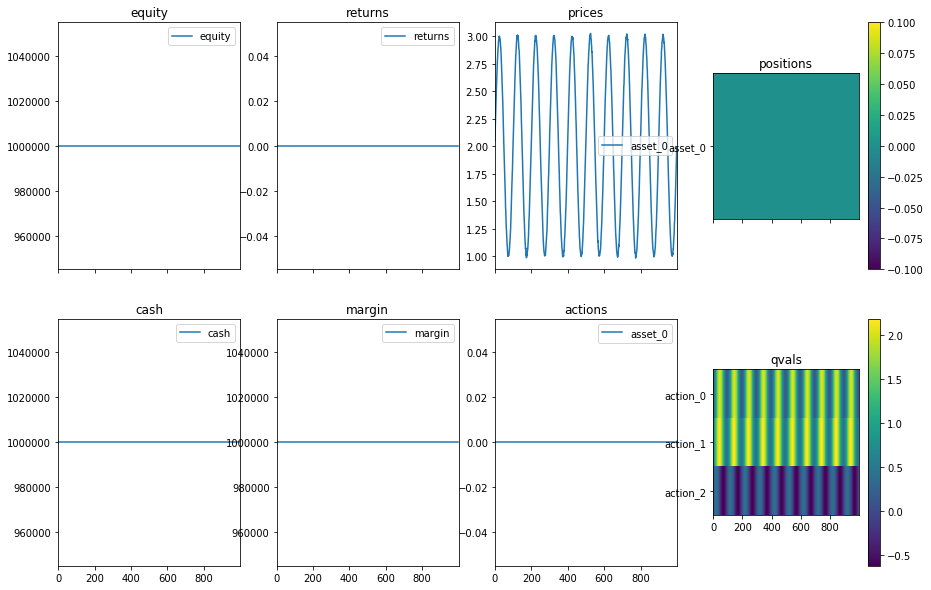

In [229]:
figsize(15, 10)
fig, ax = plot_test_metrics(tst_metrics)

In [183]:
tst_metrics['qvals'][0].shape

(3,)